In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
df.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


Логически посмотрим на данные.
1) Embarked - обозначает город посадки на борт. Не может иметь последовательной корреляции с виживаемостью на больших данных.
2) Cabin - слишком много незаполненных ячеек, попытка заполнения не может быть успешной из-за маленького объема данных
3) PassangerID - просто цифра
4) Name - имя. Является уникальным для каждого пассажира, поэтому не может иметь логическую корреляцию с целью задачи.
5) Ticket. Единственное, что эта информация может дать при очень аккуратной и сложной технически разметке - город, где покупался билет. И то это будет примерная оценка.


In [ ]:
df = df.drop('Embarked', axis=1)
df = df.drop('Cabin', axis=1)
df = df.drop('PassengerId', axis=1)
df = df.drop('Name', axis=1)
df = df.drop('Ticket', axis=1)

In [ ]:
df.isnull().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Fare,0


In [ ]:
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000
887,1,1,1,19.0,0,0,30.0000
888,0,3,1,NaN,1,2,23.4500
889,1,1,0,26.0,0,0,30.0000


Главная проблема двух графиков ниже - их интерпретация. Параментр является гибридным, поэтому, например, 1 колонке SibSp может обозначать как супруга, так и брата/сестру. Аналогичная проблема присутствует и в колонке Parch. Еще больше усложняет ситуацию то, что на титанике может быть три поколения одной семьи, или, например, дедушка с внуком, что не будет как либо зачислено в датасете. Поэтому эти колонки отбрасываются для подсчета корреляции возраста.

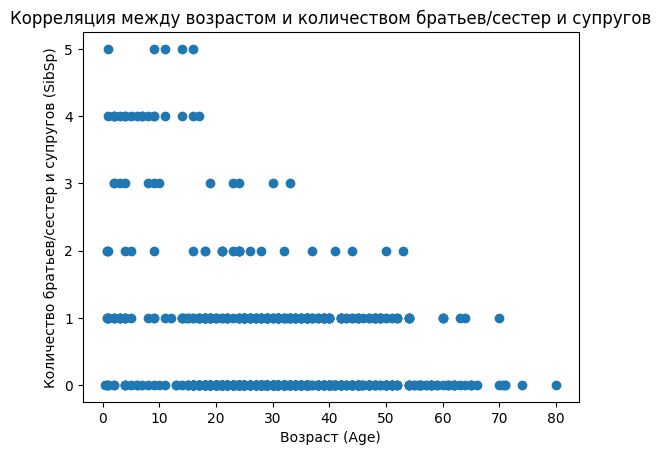

In [ ]:
plt.scatter(df['Age'], df['SibSp'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество братьев/сестер и супругов (SibSp)')
plt.title('Корреляция между возрастом и количеством братьев/сестер и супругов')
plt.show()

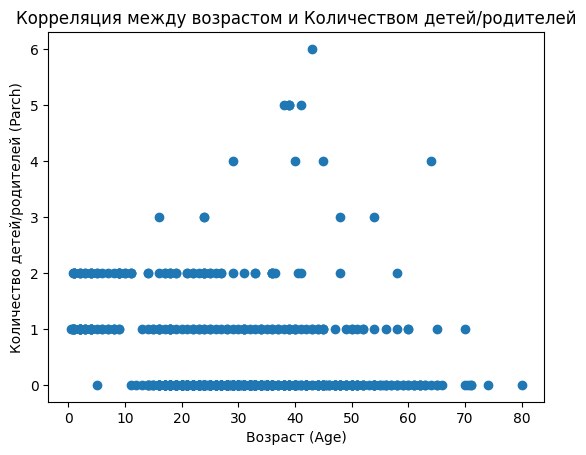

In [ ]:
plt.scatter(df['Age'], df['Parch'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Количество детей/родителей (Parch)')
plt.title('Корреляция между возрастом и Количеством детей/родителей')
plt.show()

Есть группа значений с увеличенной ценой билета возрастом от 15 до 50

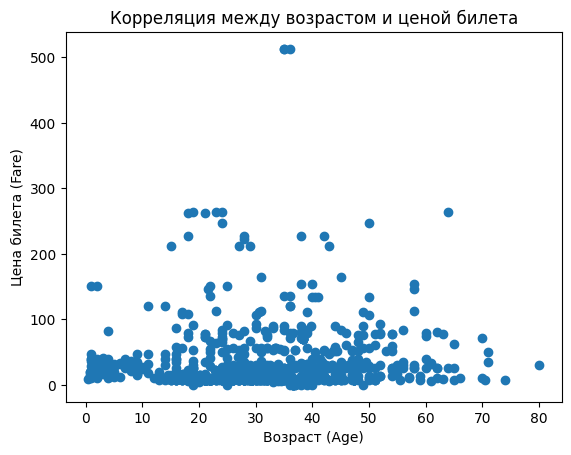

In [ ]:
plt.scatter(df['Age'], df['Fare'])
plt.xlabel('Возраст (Age)')
plt.ylabel('Цена билета (Fare)')
plt.title('Корреляция между возрастом и ценой билета')
plt.show()

Мы видим яркий провал в средней возрастной группе 20 - 50 лет

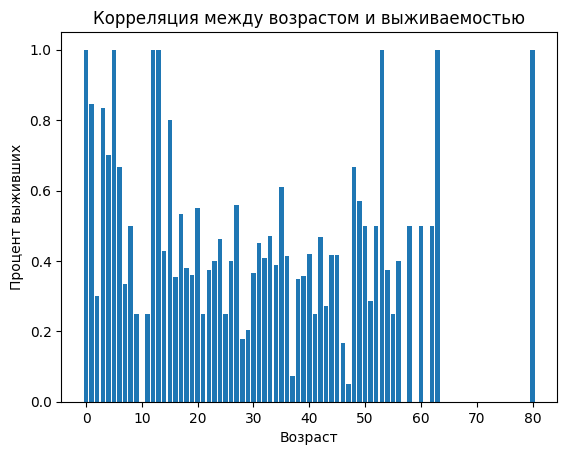

In [ ]:
rounded_ages = df['Age'].round()
survival_rates = df.groupby(rounded_ages)['Survived'].mean()
plt.bar(survival_rates.index, survival_rates.values)
plt.xlabel('Возраст')
plt.ylabel('Процент выживших')
plt.title('Корреляция между возрастом и выживаемостью')
plt.show()

Мужчины среднестатистически старше, а также у них больше крайних значений

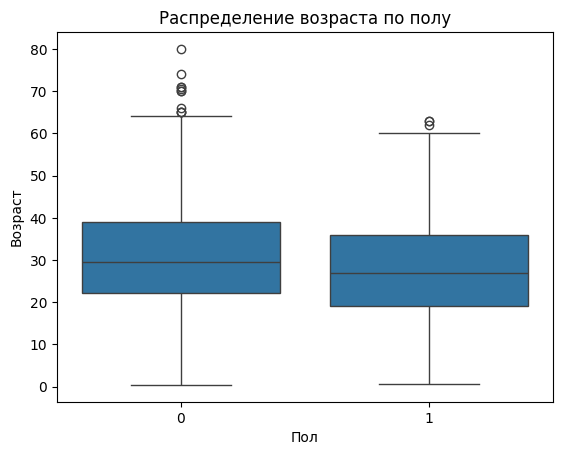

In [ ]:
sns.boxplot(x='Sex', y='Age', data=df)
plt.xlabel('Пол')
plt.ylabel('Возраст')
plt.title('Распределение возраста по полу')
plt.show()

С помощью модели K ближайших соседей выстраиваем корреляцию возраста с параметрами класса билета, пола и стоимости билета и делаем предсказание для пустых ячеек.

In [ ]:
df_train = df[~df['Age'].isnull()]
features = ['Pclass', 'Sex', 'Fare', 'Survived']
model =  sk.neighbors.KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[features], df_train['Age'])
df_test = df[df['Age'].isnull()]
predicted_age = model.predict(df_test[features])
df.loc[df['Age'].isnull(), 'Age'] = predicted_age

In [ ]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500
...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000
887,1,1,1,19.0,0,0,30.0000
888,0,3,1,27.8,1,2,23.4500
889,1,1,0,26.0,0,0,30.0000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [ ]:
X = df.drop(columns=['Survived'])
y = df['Survived']

Присутствует дизбаланс классов

In [ ]:
df['Survived'].value_counts()

,count
Survived,
0,549
1,342


По графику ниже можем заметить сильную корреляцию с колонками Fare, Pclass и сладую корреляцию с Age и Parch. Корреляция с SibSp практически отсутствует.

In [ ]:
df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,0.543351,-0.111891,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.131900,-0.357595,0.083081,0.018443,-0.549500
Sex,0.543351,-0.131900,1.000000,-0.132805,0.114631,0.245489,0.182333
Age,-0.111891,-0.357595,-0.132805,1.000000,-0.202555,-0.177871,0.091416
SibSp,-0.035322,0.083081,0.114631,-0.202555,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,0.245489,-0.177871,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.182333,0.091416,0.159651,0.216225,1.000000


In [ ]:
df = df.drop('SibSp', axis=1)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# Простая полносвязная сеть
model1 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Сеть с дропаутом
model2 = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Сеть с рекуррентным слоем
model3 = keras.Sequential([
    layers.LSTM(64, input_shape=(X_train.shape[1], 1)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

for model in [model1, model2, model3]:
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

epochs = 10
for model in [model1, model2, model3]:
    model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_test, y_test)
    )

for model in [model1, model2, model3]:
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f'Модель {model.name}:')
    print(f'Точность: {accuracy}')
    print(f'F1-мера: {f1}')

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6705 - loss: 0.7768 - val_accuracy: 0.7090 - val_loss: 0.5751
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6447 - loss: 0.6140 - val_accuracy: 0.7090 - val_loss: 0.5527
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7182 - loss: 0.5566 - val_accuracy: 0.7090 - val_loss: 0.5536
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6869 - loss: 0.5881 - val_accuracy: 0.7239 - val_loss: 0.5541
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6733 - loss: 0.5988 - val_accuracy: 0.7090 - val_loss: 0.5480
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6899 - loss: 0.5906 - val_accuracy: 0.6418 - val_loss: 0.5887
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6770 - loss: 0.5973 - val_accuracy: 0.6791 - val_loss: 0.5569
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6835 - loss: 0.5884 - val_accuracy: 0.7239 - val_loss: 0.5348
Ep